In [216]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from abc import abstractmethod

SEED=71

class Base_Model(object):
    @abstractmethod
    def fit(self, x_train, y_train, x_valid, y_valid):
        raise NotImplementedError
        
    @abstractmethod
    def predict(self, model, features):
        raise NotInplementedError

    def __init__(self, train, test, target):
        self.train = train
        self.test = test
        self.target = None
        
    def adversal_validation(self, train, test):
        train['is_train'] = 1
        test['is_train'] = 0
        all_df = pd.concat([train, test], axis=0)
        all_df = all_df.fillna(-9999)
        all_df = all_df.reset_index(drop=True)
        target = all_df['is_train'].astype(int)
        all_df = all_df.drop(columns=['is_train'])
        
        skf = StratifiedKFold(5, shuffle=True, random_state=SEED)
        
        oof_preds = np.zeros(len(all_df))
        
        for i_fold, (trn_idx, val_idx) in enumerate(skf.split(all_df, target)):
            
            x_train = all_df.iloc[trn_idx]
            y_train = target.iloc[trn_idx]
            x_val = all_df.iloc[val_idx]
            y_val = target.iloc[val_idx]
            
            model = self.fit(x_train, y_train, x_val, y_val)
            oof_preds[val_idx] = self.predict_adversal(model, x_val)
            
            oof_score = accuracy_score(y_val, np.round(oof_preds[val_idx])) # np.round : 四捨五入
            print(f'fold{i_fold}:Acc {oof_score}')
        
        oof_score = accuracy_score(target, np.round(oof_preds))
        print('-'*50)
        print(f'oof score : {oof_score}')
        
        evals_results = {"evals_results":{
            "oof_score":oof_score,
            "n_data":len(train),
            "n_features":len(train.columns)
        }}
        
        return oof_preds, evals_results
    
    
class Lgbm(Base_Model):
    def __init__(self, model_params):
        self.model_params = model_params
        self.models = []
        self.feature_cols = None
        self.feature_importance_df = pd.DataFrame()
        self.order = None
        
    def fit(self, x_train, y_train, x_valid, y_valid):
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_valid = lgb.Dataset(x_valid, y_valid)
        
        model = lgb.train(self.model_params,
                         train_set=lgb_train,
                         valid_sets=[lgb_valid],
                         early_stopping_rounds=20,
                         num_boost_round=999999,
                         verbose_eval=False)
        
        self.models.append(model)
        return model
    
    def predict(self, model, feature):
        self.feature_cols = features.columns
        return np.argmax(model.predict(features), axis=1)
    
    def predict_adversal(self, model, features):
        self.feature_cols = features.columns
        return model.predict(features)
    
    def visualize_importance(self):
        for i, model in enumerate(self.models):
            _df = pd.DataFrame()
            _df['feature_importance'] = model.feature_importance(importance_type='gain')
            _df['column'] = self.feature_cols
            _df['fold'] = i+1
            self.feature_importance_df = pd.concat([self.feature_importance_df, _df], axis=0, ignore_index=True)
            
        # feature_importanceの総和が高い順に並び替え、その順に表示する
        self.order = self.feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance', ascending=False).index[:50]
    
        fig, ax = plt.subplots(2, 1, figsize=(max(6, len(self.order) * .4), 14))
        sns.boxenplot(data=self.feature_importance_df, x='column', y='feature_importance', order=self.order, ax=ax[0], palette='viridis')
        ax[0].tick_params(axis='x', rotation=90)
        ax[0].grid()
        fig.tight_layout()
        return fig, ax

fold0:Acc 0.48610253242742435
fold1:Acc 0.5083384805435454
fold2:Acc 0.49443757725587145
fold3:Acc 0.4919653893695921
fold4:Acc 0.5129789864029666
--------------------------------------------------
oof score : 0.49876421156697975


(<Figure size 432x1008 with 2 Axes>,
 array([<AxesSubplot:xlabel='column', ylabel='feature_importance'>,
        <AxesSubplot:>], dtype=object))

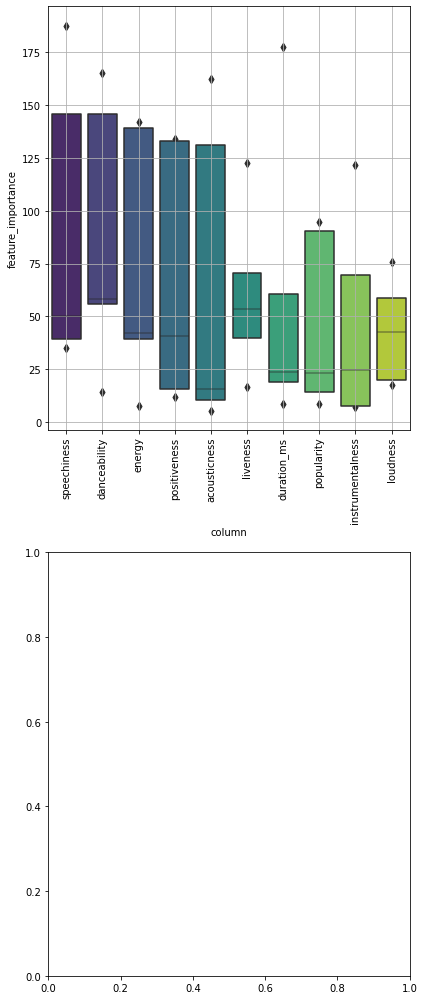

In [222]:
train = pd.read_csv('../data/train.csv')
train_feat_df = train.drop(['genre', 'index', 'tempo', 'region'], axis=1)
test = pd.read_csv('../data/test.csv')
test_feat_df = test.drop(['index', 'tempo', 'region'], axis=1)


params = {'boosting_type': 'gbdt',
          'objective': 'cross_entropy',
          'verbosity':-1}

model = Lgbm(params)
model.adversal_validation(train_feat_df,test_feat_df)
model.visualize_importance()
